## Parte 1 — Base del experimento (datos + preparación)

En esta primera parte se construye la base necesaria para entrenar una PINN del ORC con un modelo dinámico 0D (lumped), enfocándonos inicialmente en dos variables térmicas:

- $T_{ev}(t)$: temperatura asociada al evaporador  
- $T_{cd}(t)$: temperatura asociada al condensador  

### [B1] Parámetros y entrada $Q_{in}(t)$
Se define el dominio temporal $t \in [t_0, t_1]$, condiciones iniciales $T_{ev}(0)$ y $T_{cd}(0)$, y una entrada térmica $Q_{in}(t)$ tipo escalón:
- Antes de $t=40\,s$: $Q_{in}(t)=0$
- Después de $t=40\,s$: $Q_{in}(t)=1200$

Además se fijan parámetros "reales" ($C_{ev}$, $C_{cd}$, $k_{ev}$, $k_{cd}$, $k_{out}$) que se usan únicamente para **generar datos sintéticos** y validar la PINN.

### [B2] Simulación y creación de observaciones
Se simula un sistema de ecuaciones diferenciales ordinarias (ODEs) simplificadas:

$$
C_{ev}\,\frac{dT_{ev}}{dt} = Q_{in}(t) - k_{ev}(T_{ev} - T_{amb})
$$

$$
C_{cd}\,\frac{dT_{cd}}{dt} = k_{cd}(T_{ev} - T_{cd}) - k_{out}(T_{cd} - T_{amb})
$$

La integración se realiza con un método simple (Euler explícito) para producir trayectorias "verdaderas".  
Luego se agrega ruido gaussiano para emular mediciones reales y obtener $T_{ev}^{obs}(t)$ y $T_{cd}^{obs}(t)$.

### [B3] Preparación del dataset para la PINN
Se construyen los arreglos con el formato típico que usará DeepXDE:

- Entrada: $X = [t] \in \mathbb{R}^{N \times 1}$
- Salida observada: $Y = [T_{ev}^{obs}, T_{cd}^{obs}] \in \mathbb{R}^{N \times 2}$

Estos datos serán usados en la parte siguiente como **términos de ajuste a datos** dentro de la función de pérdida de la PINN.


In [22]:
# ==========================================
# [B1] IMPORTS + SEMILLA + PARÁMETROS
# ==========================================
import numpy as np
import matplotlib.pyplot as plt

# Semilla para reproducibilidad
np.random.seed(42)

# ---- Dominio temporal ----
t0 = 0.0
t1 = 200.0          # segundos (puedes cambiarlo)
N_data = 120        # número de observaciones (para datos sintéticos)

# ---- Parámetros "reales" del sistema (para generar datos sintéticos) ----
# Modelo dinámico 0D (simplificado):
#   C_ev * dT_ev/dt   = Q_in(t)  - k_ev*(T_ev - T_amb)
#   C_cd * dT_cd/dt   = k_cd*(T_ev - T_cd) - k_out*(T_cd - T_amb)
#
# NOTA: Esto es una aproximación estable y útil para PINNs iniciales.

C_ev_true  = 50.0
C_cd_true  = 80.0
k_ev_true  = 1.20
k_cd_true  = 0.60
k_out_true = 0.90

T_amb = 25.0

# ---- Condiciones iniciales ----
T_ev_0 = 30.0
T_cd_0 = 28.0

# ---- Entrada térmica (fuente de calor) ----
def Q_in(t):
    # Escalón suave: 0 hasta t=40, luego 1200 (W) hasta el final
    return 1200.0 * (t >= 40.0)

# ---- Ruido (para simular medición) ----
sigma_T = 0.25  # °C


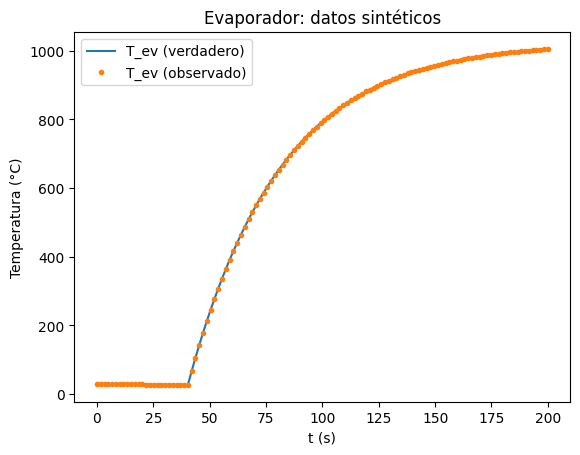

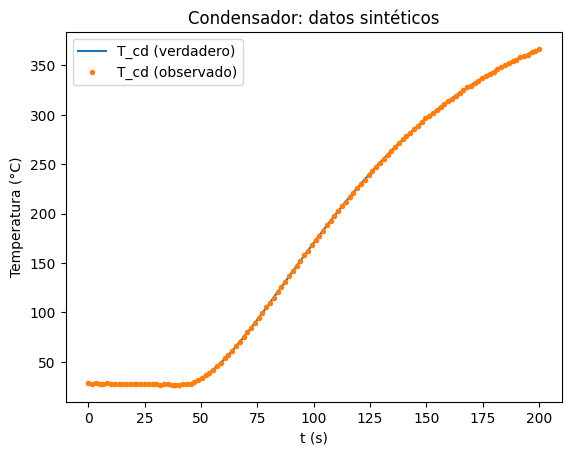

In [23]:
# ==========================================
# [B2] GENERACIÓN DE DATOS SINTÉTICOS (SIMULACIÓN)
# ==========================================
# Integramos con un método simple (Euler explícito) para generar "mediciones"
ts = np.linspace(t0, t1, N_data)
dt = ts[1] - ts[0]

T_ev = np.zeros_like(ts)
T_cd = np.zeros_like(ts)

T_ev[0] = T_ev_0
T_cd[0] = T_cd_0

for i in range(1, len(ts)):
    t = ts[i-1]

    dT_ev = (Q_in(t) - k_ev_true*(T_ev[i-1] - T_amb)) / C_ev_true
    dT_cd = (k_cd_true*(T_ev[i-1] - T_cd[i-1]) - k_out_true*(T_cd[i-1] - T_amb)) / C_cd_true

    T_ev[i] = T_ev[i-1] + dt*dT_ev
    T_cd[i] = T_cd[i-1] + dt*dT_cd

# Agregar ruido como si fueran sensores
T_ev_obs = T_ev + np.random.normal(0, sigma_T, size=T_ev.shape)
T_cd_obs = T_cd + np.random.normal(0, sigma_T, size=T_cd.shape)

# Graficar
plt.figure()
plt.plot(ts, T_ev, label="T_ev (verdadero)")
plt.plot(ts, T_ev_obs, ".", label="T_ev (observado)")
plt.xlabel("t (s)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.title("Evaporador: datos sintéticos")
plt.show()

plt.figure()
plt.plot(ts, T_cd, label="T_cd (verdadero)")
plt.plot(ts, T_cd_obs, ".", label="T_cd (observado)")
plt.xlabel("t (s)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.title("Condensador: datos sintéticos")
plt.show()


In [24]:
# ==========================================
# [B3] PREPARAR DATASETS PARA LA PINN
# ==========================================
# DeepXDE usualmente espera:
#   X: (N, 1)  (aquí: tiempo)
#   Y: (N, n_outputs)  (aquí: [T_ev, T_cd])

X_data = ts.reshape(-1, 1)  # (N,1)
Y_data = np.column_stack([T_ev_obs, T_cd_obs])  # (N,2)

print("X_data:", X_data.shape, "| Y_data:", Y_data.shape)
print("Ejemplo X[0], Y[0]:", X_data[0], Y_data[0])


X_data: (120, 1) | Y_data: (120, 2)
Ejemplo X[0], Y[0]: [0.] [30.12417854 28.19775799]


In [26]:
# ==========================================
# [B4] DEEPXDE: IMPORTS + BACKEND + CONFIG
# ==========================================
import deepxde as dde
import numpy as np

# DeepXDE usa por defecto TensorFlow (si está instalado). Verificamos backend:
print("DeepXDE backend:", dde.backend.backend_name)

# Configuración útil para reproducibilidad
dde.config.set_random_seed(42)

# (Opcional) Si tu entorno tiene problemas de precisión numérica,
# puedes usar float64; esto mejora estabilidad en PINNs, pero puede ser más lento.
# dde.config.set_default_float("float64")
# print("DeepXDE float dtype:", dde.config.real(np))

# (Opcional) Para ver más info al entrenar
dde.config.set_default_autodiff("reverse")  # reverse suele ser más estable en PINNs
print("Autodiff:", dde.config.autodiff)

# Chequeos mínimos
assert "deepxde" in str(dde.__file__).lower()
print("DeepXDE listo ✅")

DeepXDE backend: tensorflow
Set the default automatic differentiation to reverse mode.
Autodiff: reverse
DeepXDE listo ✅


Y_data_3: (120, 3)


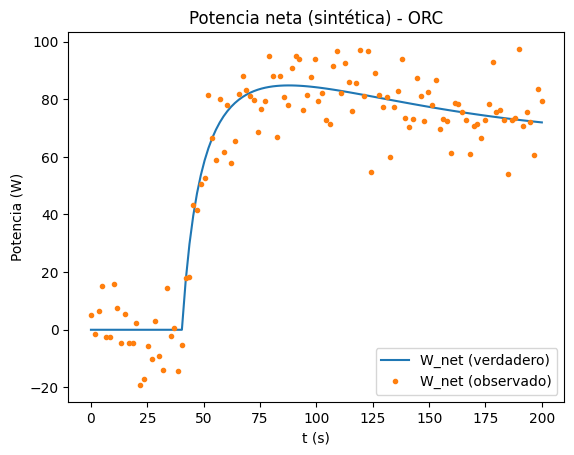

In [27]:



### ```python
# ==========================================
# [B5] CONSTRUIR UNA OBSERVACIÓN DE POTENCIA (SINTÉTICA)
# ==========================================
# Para petróleo y gas: Q_in(t) representa el calor recuperable del agua coproducida:
# Q_in(t) ~ m_dot_pw * cp_pw * (T_pw_in - T_pw_out)
# Por ahora usamos Q_in(t) definido en Parte 1.

# Modelo de potencia aproximado (Carnot + eficiencia efectiva):
#   W_net(t) = eta_orc * Q_in(t) * (1 - T_cdK/T_evK)
# donde eta_orc es una "eficiencia efectiva" (incluye turbina+generador+pérdidas)
eta_orc_true = 0.12  # valor típico bajo-moderado para fuentes de baja/media T
sigma_W = 10.0       # ruido de potencia (W)

def Wnet_from_T(T_ev_C, T_cd_C, t):
    T_evK = T_ev_C + 273.15
    T_cdK = T_cd_C + 273.15
    carnot = 1.0 - (T_cdK / T_evK)
    return eta_orc_true * Q_in(t) * np.maximum(carnot, 0.0)

W_net_true = np.array([Wnet_from_T(T_ev[i], T_cd[i], ts[i]) for i in range(len(ts))])
W_net_obs  = W_net_true + np.random.normal(0, sigma_W, size=W_net_true.shape)

# Dataset ahora con 3 salidas: [T_ev, T_cd, W_net]
Y_data_3 = np.column_stack([T_ev_obs, T_cd_obs, W_net_obs])

print("Y_data_3:", Y_data_3.shape)

# Visual rápido
plt.figure()
plt.plot(ts, W_net_true, label="W_net (verdadero)")
plt.plot(ts, W_net_obs, ".", label="W_net (observado)")
plt.xlabel("t (s)")
plt.ylabel("Potencia (W)")
plt.legend()
plt.title("Potencia neta (sintética) - ORC")
plt.show()


In [28]:
# ==========================================
# [B6] PARÁMETROS ENTRENABLES + ENTRADA Q_in(t) EN TENSOR
# ==========================================
# Este bloque define variables físicas entrenables (PIML)
# y una versión de Q_in(t) compatible con el backend de DeepXDE (TensorFlow).

# ---- Parámetros aprendibles ----
C_ev   = dde.Variable(40.0)   # capacidad térmica equivalente evaporador
C_cd   = dde.Variable(90.0)   # capacidad térmica equivalente condensador
k_ev   = dde.Variable(1.0)    # pérdidas/transferencia hacia ambiente evaporador
k_cd   = dde.Variable(0.5)    # acoplamiento térmico ev->cd
k_out  = dde.Variable(1.0)    # pérdidas/transferencia del condensador al ambiente
eta_orc = dde.Variable(0.08)  # eficiencia efectiva ORC (0-0.25 típico en baja T)

# ---- Chequeos de rango (opcional) ----
print("\n===== Inicialización parámetros (trainables) =====")
print("C_ev   =", float(C_ev.value()))
print("C_cd   =", float(C_cd.value()))
print("k_ev   =", float(k_ev.value()))
print("k_cd   =", float(k_cd.value()))
print("k_out  =", float(k_out.value()))
print("eta_orc =", float(eta_orc.value()))

# ---- Entrada térmica Q_in(t) en TensorFlow ----
# Si estás usando backend TF (lo más común), definimos Q_in_tf.
# En Parte 1 Q_in(t) era un escalón: 0 hasta 40s, luego 1200W.
# Aquí hacemos lo mismo, pero en tensor.

import tensorflow as tf

# Asegurar consistencia de tipo numérico
T_amb_const = float(T_amb)  # usa el valor de Parte 1

@tf.function
def Q_in_tf(t):
    """
    t: tensor shape (N,1) o (N,)
    retorna: tensor shape (N,1) con Q_in(t) en W
    """
    t = tf.reshape(t, (-1, 1))
    return tf.where(t >= 40.0, 1200.0, 0.0)

# Prueba rápida
t_test = tf.constant([[0.0], [39.9], [40.0], [80.0]], dtype=tf.float32)
print("\nQ_in_tf test:", Q_in_tf(t_test).numpy().ravel())
print("Bloque [B6] listo ✅")



===== Inicialización parámetros (trainables) =====
C_ev   = 40.0
C_cd   = 90.0
k_ev   = 1.0
k_cd   = 0.5
k_out  = 1.0
eta_orc = 0.07999999821186066

Q_in_tf test: [   0.    0. 1200. 1200.]
Bloque [B6] listo ✅


In [29]:


### ```python
# ==========================================
# [B7] DEFINIR EL RESIDUAL FÍSICO (ODEs + ECUACIÓN DE POTENCIA)
# ==========================================
# Salida de la red: y(t) = [T_ev, T_cd, W_net]
# Residuales:
# r1: C_ev dT_ev/dt - (Q_in - k_ev(T_ev - T_amb)) = 0
# r2: C_cd dT_cd/dt - (k_cd(T_ev - T_cd) - k_out(T_cd - T_amb)) = 0
# r3: W_net - eta_orc * Q_in * (1 - T_cdK/T_evK) = 0

T_amb_const = float(T_amb)

def orc_residual(t, y):
    T_ev_pred = y[:, 0:1]
    T_cd_pred = y[:, 1:2]
    W_pred    = y[:, 2:3]

    dT_ev_dt = dde.grad.jacobian(y, t, i=0, j=0)
    dT_cd_dt = dde.grad.jacobian(y, t, i=1, j=0)

    Qin = Q_in_tf(t)  # (N,1)

    # Residuales térmicos
    r1 = C_ev * dT_ev_dt - (Qin - k_ev * (T_ev_pred - T_amb_const))
    r2 = C_cd * dT_cd_dt - (k_cd * (T_ev_pred - T_cd_pred) - k_out * (T_cd_pred - T_amb_const))

    # Residual potencia (Carnot + eficiencia efectiva)
    T_evK = T_ev_pred + 273.15
    T_cdK = T_cd_pred + 273.15
    carnot = 1.0 - (T_cdK / T_evK)

    r3 = W_pred - eta_orc * Qin * tf.maximum(carnot, 0.0)

    return [r1, r2, r3]


In [30]:
# ==========================================
# [B8] GEOMETRÍA + BCs A DATOS (PointSetBC) + ICs + DATASET TimePDE
# ==========================================
# Este bloque:
# 1) Define el dominio temporal
# 2) Crea restricciones a datos observados (temperaturas y potencia)
# 3) Define condiciones iniciales
# 4) Construye el objeto data = TimePDE para DeepXDE

# ---- Chequeos previos: asegúrate de tener estos objetos de la Parte 1 y 2 ----
required = ["t0", "t1", "X_data", "Y_data_3", "T_ev_0", "T_cd_0"]
missing = [r for r in required if r not in globals()]
if missing:
    raise ValueError(f"Faltan variables antes de [B8]: {missing}")

assert X_data.ndim == 2 and X_data.shape[1] == 1, "X_data debe ser (N,1)"
assert Y_data_3.ndim == 2 and Y_data_3.shape[1] == 3, "Y_data_3 debe ser (N,3)=[T_ev,T_cd,W_net]"

# ---- Dominio temporal ----
geom = dde.geometry.TimeDomain(t0, t1)

# ---- Puntos de observación ----
X_obs = X_data  # (N,1)

# ---- Restricciones por datos (PointSetBC) ----
# component=0 -> T_ev
# component=1 -> T_cd
# component=2 -> W_net
bc_Tev = dde.icbc.PointSetBC(X_obs, Y_data_3[:, 0:1], component=0)
bc_Tcd = dde.icbc.PointSetBC(X_obs, Y_data_3[:, 1:2], component=1)
bc_W   = dde.icbc.PointSetBC(X_obs, Y_data_3[:, 2:3], component=2)

# ---- Condiciones iniciales (IC) ----
# on_initial indica el borde inicial t=t0.
ic_Tev = dde.icbc.IC(
    geom,
    lambda x: T_ev_0,
    lambda _, on_initial: on_initial,
    component=0
)

ic_Tcd = dde.icbc.IC(
    geom,
    lambda x: T_cd_0,
    lambda _, on_initial: on_initial,
    component=1
)

# ---- Dataset TimePDE ----
# num_domain: puntos internos para residuales físicos
# num_boundary: puntos de borde (incluye t=t0)
# anchors: fuerza a incluir puntos medidos dentro del muestreo del dominio
data = dde.data.TimePDE(
    geom,
    orc_residual,                 # residual físico definido en [B7]
    [bc_Tev, bc_Tcd, bc_W, ic_Tev, ic_Tcd],
    num_domain=400,
    num_boundary=20,
    anchors=X_obs
)

print("Bloque [B8] listo ✅")
print("Dominio:", (t0, t1))
print("Observaciones:", X_obs.shape[0], "puntos")


Bloque [B8] listo ✅
Dominio: (0.0, 200.0)
Observaciones: 120 puntos


In [31]:

import deepxde as dde

### ```python
# ==========================================
# [B9] RED + ENTRENAMIENTO (Adam)
# ==========================================
net = dde.nn.FNN([1, 64, 64, 64, 3], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Pesos de la loss:
# [r1, r2, r3, bc_Tev, bc_Tcd, bc_W, ic_Tev, ic_Tcd]
loss_weights = [1.0, 1.0, 1.0, 50.0, 50.0, 10.0, 20.0, 20.0]

model.compile("adam", lr=1e-3, loss_weights=loss_weights,
              external_trainable_variables=[C_ev, C_cd, k_ev, k_cd, k_out, eta_orc])

losshistory, train_state = model.train(epochs=6000, display_every=500)

# Mostrar parámetros aprendidos
print("\n===== PARÁMETROS APRENDIDOS =====")
print("C_ev  =", float(C_ev.value()))
print("C_cd  =", float(C_cd.value()))
print("k_ev  =", float(k_ev.value()))
print("k_cd  =", float(k_cd.value()))
print("k_out =", float(k_out.value()))
print("eta_orc =", float(eta_orc.value()))


Compiling model...
'compile' took 0.006700 s

Training model...



Cause: could not parse the source code of <function <lambda> at 0x78c9f4a0f600>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x78c9f4a0f600>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x78c9f4a0fa60>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x78c9f4a0fa60>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.18e+06, 5.92e+02, 1.56e-01, 2.65e+07, 2.29e+06, 4.76e+04, 1.80e+04, 1.57e+04]    [1.18e+06, 5.92e+02, 1.56e-01, 2.65e+07, 2.29e+06, 4.76e+04, 1.80e+04, 1.57e+04]    []  
500       [1.10e+06, 5.95e+01, 2.43e+02, 2.41e+07, 1.75e+06, 2.09e+04, 2.32e+03, 7.44e+02]    [1.10e+06, 5.95e+01, 2.43e+02, 2.41e+07, 1.75e+06


====== MÉTRICAS (sobre puntos observados) ======
  T_ev | MAE =   343.7076 | MSE =  181072.3097 | R2 =  -0.2713
  T_cd | MAE =    65.2730 | MSE =    6622.5554 | R2 =   0.5703
 W_net | MAE =     8.1009 | MSE =     101.8027 | R2 =   0.9128


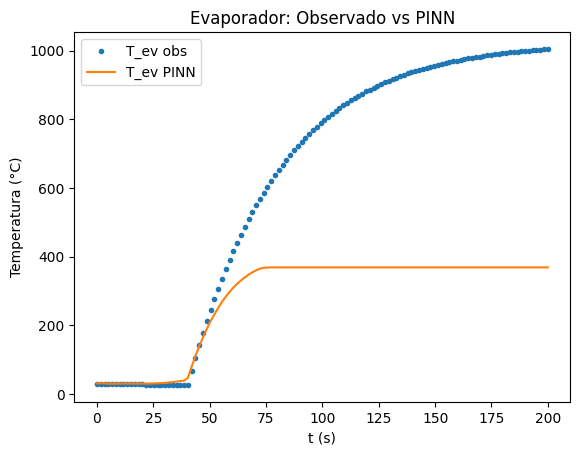

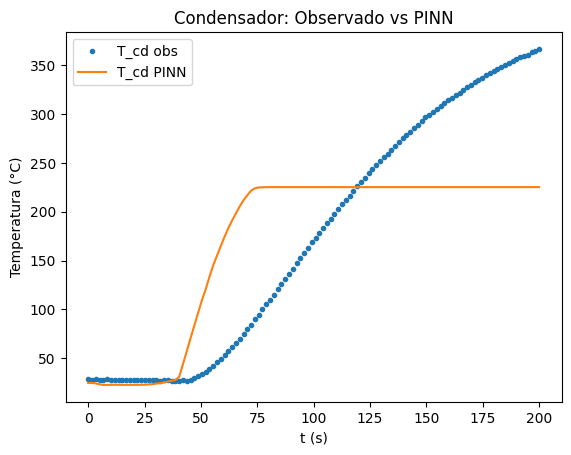

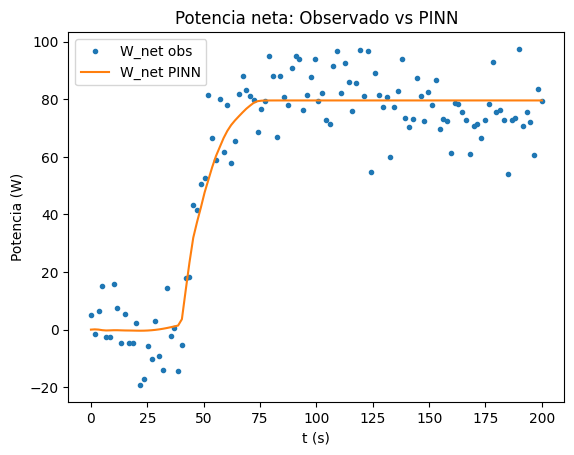

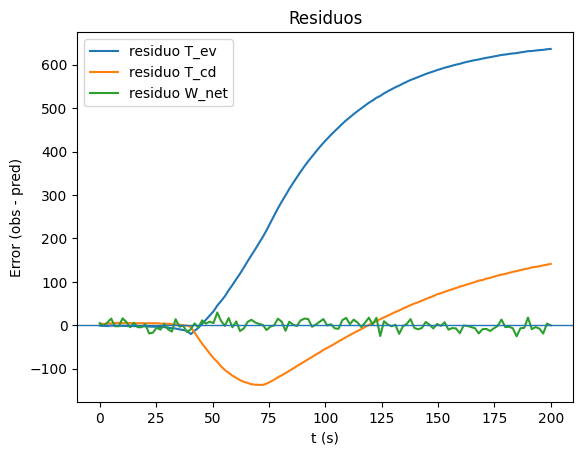


===== PARÁMETROS APRENDIDOS (si están definidos) =====
    C_ev = 43.992283
    C_cd = 82.190155
    k_ev = 3.722397
    k_cd = 7.275249
   k_out = 5.023772
 eta_orc = 0.284568


In [32]:
# ==========================================
# [B10] PREDICCIÓN + MÉTRICAS (MAE, MSE, R2) + GRÁFICAS
# ==========================================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- Chequeos previos ----
required = ["model", "X_data", "Y_data_3", "ts"]
missing = [r for r in required if r not in globals()]
if missing:
    raise ValueError(f"Faltan variables antes de [B10]: {missing}")

assert X_data.ndim == 2 and X_data.shape[1] == 1, "X_data debe ser (N,1)"
assert Y_data_3.ndim == 2 and Y_data_3.shape[1] == 3, "Y_data_3 debe ser (N,3)=[T_ev,T_cd,W_net]"
assert len(ts) == X_data.shape[0] == Y_data_3.shape[0], "ts, X_data, Y_data_3 deben tener el mismo N"

# ---- Predicción de la PINN en puntos observados ----
Y_pred = model.predict(X_data)  # (N,3)

# ---- Métricas por salida ----
def report_metrics(y_true, y_hat, name):
    mae = mean_absolute_error(y_true, y_hat)
    mse = mean_squared_error(y_true, y_hat)
    r2  = r2_score(y_true, y_hat)
    print(f"{name:>6s} | MAE = {mae:10.4f} | MSE = {mse:12.4f} | R2 = {r2:8.4f}")
    return mae, mse, r2

print("\n====== MÉTRICAS (sobre puntos observados) ======")
mae_ev, mse_ev, r2_ev = report_metrics(Y_data_3[:,0], Y_pred[:,0], "T_ev")
mae_cd, mse_cd, r2_cd = report_metrics(Y_data_3[:,1], Y_pred[:,1], "T_cd")
mae_W,  mse_W,  r2_W  = report_metrics(Y_data_3[:,2], Y_pred[:,2], "W_net")

# ---- Gráficas: Observado vs PINN ----
plt.figure()
plt.plot(ts, Y_data_3[:,0], ".", label="T_ev obs")
plt.plot(ts, Y_pred[:,0], "-", label="T_ev PINN")
plt.xlabel("t (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Evaporador: Observado vs PINN")
plt.legend()
plt.show()

plt.figure()
plt.plot(ts, Y_data_3[:,1], ".", label="T_cd obs")
plt.plot(ts, Y_pred[:,1], "-", label="T_cd PINN")
plt.xlabel("t (s)")
plt.ylabel("Temperatura (°C)")
plt.title("Condensador: Observado vs PINN")
plt.legend()
plt.show()

plt.figure()
plt.plot(ts, Y_data_3[:,2], ".", label="W_net obs")
plt.plot(ts, Y_pred[:,2], "-", label="W_net PINN")
plt.xlabel("t (s)")
plt.ylabel("Potencia (W)")
plt.title("Potencia neta: Observado vs PINN")
plt.legend()
plt.show()

# ---- (Opcional) Residuos ----
res_ev = Y_data_3[:,0] - Y_pred[:,0]
res_cd = Y_data_3[:,1] - Y_pred[:,1]
res_W  = Y_data_3[:,2] - Y_pred[:,2]

plt.figure()
plt.plot(ts, res_ev, label="residuo T_ev")
plt.plot(ts, res_cd, label="residuo T_cd")
plt.plot(ts, res_W,  label="residuo W_net")
plt.axhline(0, linewidth=1)
plt.xlabel("t (s)")
plt.ylabel("Error (obs - pred)")
plt.title("Residuos")
plt.legend()
plt.show()

# ---- Mostrar parámetros aprendidos si existen ----
print("\n===== PARÁMETROS APRENDIDOS (si están definidos) =====")
for name in ["C_ev", "C_cd", "k_ev", "k_cd", "k_out", "eta_orc"]:
    if name in globals():
        try:
            val = float(globals()[name].value())
            print(f"{name:>8s} = {val:.6f}")
        except Exception:
            print(f"{name:>8s} = (no se pudo leer)")
    else:
        print(f"{name:>8s} = (no definido)")
